In [1]:
import multiprocessing   as mp
import numpy             as np


import gym
import Portfolio_Gym
import A2C_V as A2C
import Factors_Wrapper as Wrapper

# Single Asset Merton Model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
  0%|          | 0/50000 [00:00<?, ?it/s]/Users/jakefowler/Documents/GitHub/rl-portfolio/Gym Environments/Portfolio_Management/Portfolio_Gym/envs/Simulated.py:218: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self._Factor_Model_R

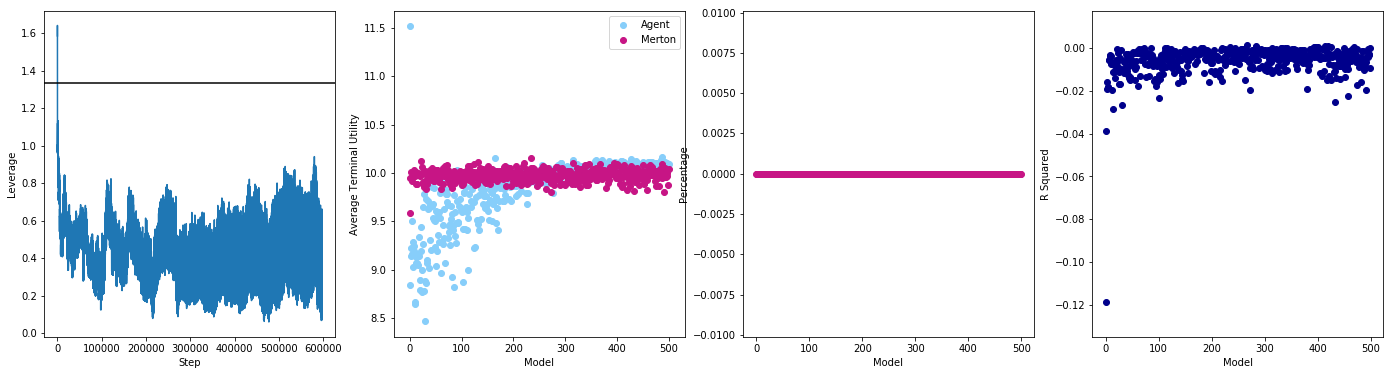

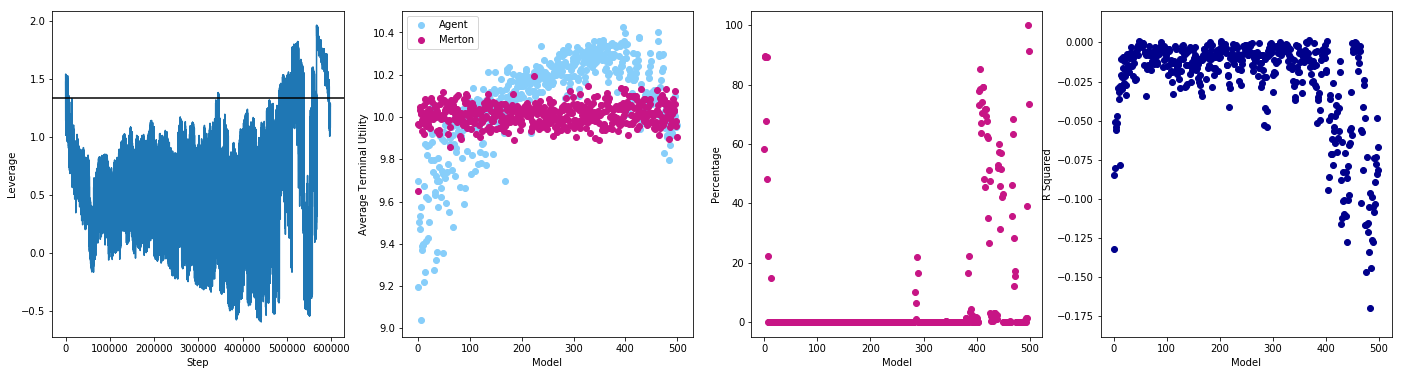

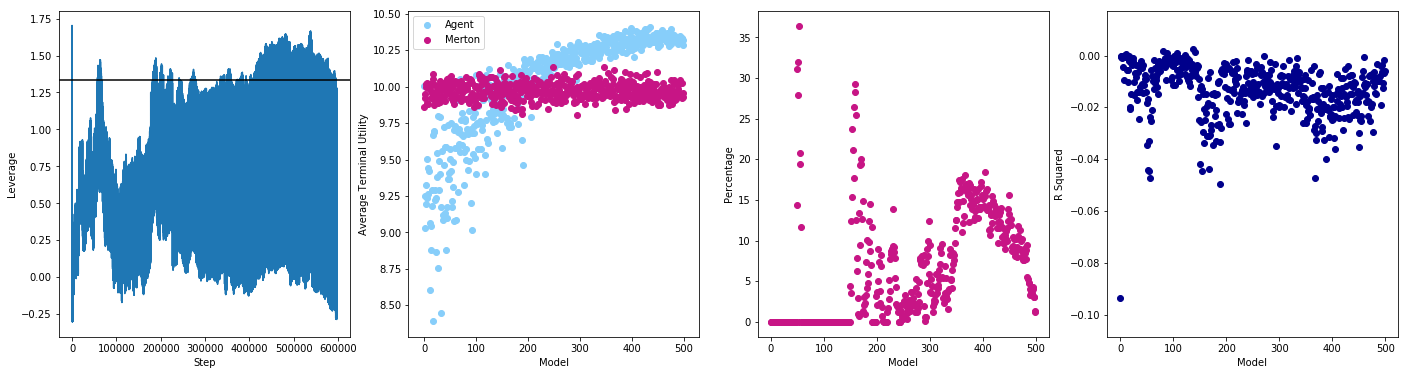

In [5]:
# Model Parameters.
Gamma  = (1 + 0.01) ** (0.9 - 1)
N_Eps  = int(5e4)

Actor_Hypers   = {"Learning Rate" : 0.075,
                  "Epoch"         : 3,
                  "Network Size"  : [8,8],
                  "Activation"    : "Sigmoid",
                  "Alpha"         : 0.0,
                  "Batch Size"    : 0}

Critic_Hypers = {"Learning Rate" : 0.075,
                 "Epoch"         : 3,
                 "Network Size"  : [8,8],
                 "Activation"    : "Sigmoid",
                 "Alpha"         : 0.0,
                 "Batch Size"    : 0}


# Function to facilitate mulitprocessing.
def Run(seed):
    np.random.seed(seed)
    Merton_Env = gym.make('Simulated-v0')
    Merton_Env.Set_Params(Mu = 0.06, Sigma = 0.35, Row = 1, Rf = 0.01,
                          Max_Leverage  = 750,
                          Min_Leverage  = -750,
                          Time_Horizon  = 1,
                          Time_Step     = 1/12,
                          Risk_Aversion = 0.9,
                          State_Corrolations = [0.5, 1.0])
 
    myAC = A2C.Actor_Critic(Merton_Env, Actor_Hypers, Critic_Hypers, 
                            Gamma = Gamma,    Sigma_Range = [2, 0.05],
                            Sigma_Anneal = 1, Retrain_Frequency = 100)
    
    myWrapper = Wrapper.Factors_Wrapper(myAC)
    myWrapper.Train(N_Eps, Plot = ['Mu', 'R_Squared', 'Merton_Benchmark', 'Percent_Merton_Action'])


# Run the investigation...
with mp.Pool(mp.cpu_count()) as pool:
    _ = pool.map(Run, np.random.randint(0, int(1e9), 3))
